MICE: Multiple Imputation through Chained Equations
===================================================

This is a simulation study illustrating the statsmodels MICE capabilities.

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.sandbox.mice import mice

### Example 1

As a first example, we look at a situation where there is a non-linear relationship among the covariates.  First we run the MICE procedure with defaults, which means that only main effects will be included in each imputation model.

Here is the code to simulate the data:

In [2]:
n = 500
p = 5

# Simulate complete data
exog = np.random.normal(size=(n, p))
exog[:, 0] += exog[:, 1]
exog[:, 4] = exog[:,3]**2 + 0.5*np.random.normal(size=n)
endog = exog[:, 0] + exog[:, 1] - exog[:, 2] + np.random.normal(size=n)

# Create some missing values
exog[0:100, 1] = np.nan
exog[50:150, 2] = np.nan
exog[200:300, 4] = np.nan
endog[100:200] = np.nan

data = pd.DataFrame(exog)
data.columns = ["x%d" % (j+1) for j in range(p)]
data["y"] = endog

Here is the code to set up the MICE object.  This involves two steps.  First we create a `MICEData` object that manages the imputations for each variable in the data frame, then we create a `MICE` object that specifies the analysis model of interest.  The `MICE` object knows how to combine the fits obtained from multiple imputed data sets to produce a single overall result for the model of interest.

In [3]:
idata = mice.MICEData(data)
fml = "y ~ x1 + x2 + x3 + x4 + x5"
mi = mice.MICE(fml, sm.OLS, idata)

We can make a simple plot to show the missing data pattern.

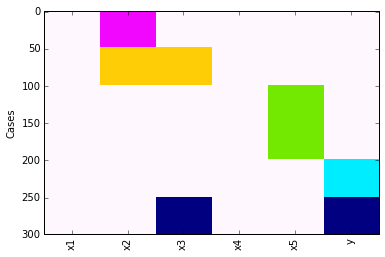

In [4]:
_ = idata.plot_missing_pattern(hide_complete_rows=True)

This is where most of the work takes place:

In [5]:
result = mi.fit(10, 10)

The scatterplot in the next cell reveals that the imputation model for `x5` has not captured the mean structure very well.  This is expected because the true mean structure is a pure quadratic function. We can also look at the model summary for `x5` in the final imputation cycle.  Note that `x5` is not predictable from any of the other covariates when using a model that contains only main effects.

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.8864
Date:                Sat, 14 Nov 2015   Prob (F-statistic):              0.490
Time:                        17:21:59   Log-Likelihood:                -728.03
No. Observations:                 400   AIC:                             1468.
Df Residuals:                     394   BIC:                             1492.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0522      0.076     13.933      0.0

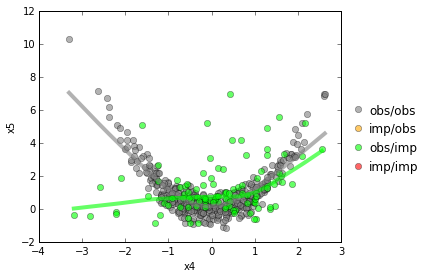

In [6]:
_ = idata.plot_bivariate("x4", "x5")
print(idata.results['x5'].summary())

To address this, we set a mean structure for imputing `x5` that allows a quadratic effect for `x4`.

In [7]:
idata2 = mice.MICEData(data)
idata2.set_imputer('x5', formula='x1 + x2 + x3 + x4 + np.square(x4)')

In [8]:
fml = "y ~ x1 + x2 + x3 + x4 + x5"
mi2 = mice.MICE(fml, sm.OLS, idata2)
mi2_result = mi2.fit(10, 10)

Now the fit is much better:

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     645.9
Date:                Sat, 14 Nov 2015   Prob (F-statistic):          2.57e-187
Time:                        17:22:07   Log-Likelihood:                -286.50
No. Observations:                 400   AIC:                             585.0
Df Residuals:                     394   BIC:                             608.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0409      0.032     -1.288      0.1

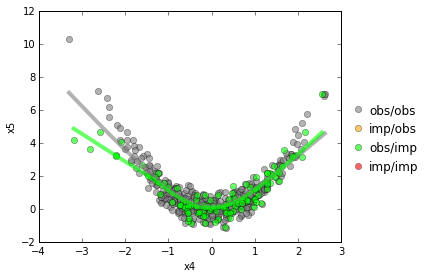

In [9]:
_ = idata2.plot_bivariate("x4", "x5")
print(idata2.results['x5'].summary())

Here is the summary for the analysis model.  It correctly identifies the variables that should predict `y`.

In [10]:
print(mi2_result.summary())

                          Results: MICE
Method:                    MICE       Sample size:           500 
Model:                     OLS        Scale                  1.04
Dependent variable:        y          Num. imputations       10  
-----------------------------------------------------------------
           Coef.  Std.Err.    t     P>|t|   [0.025  0.975]  FMI  
-----------------------------------------------------------------
Intercept -0.0334   0.0739  -0.4522 0.6511 -0.1782  0.1114 0.4211
x1         1.0242   0.0589  17.3769 0.0000  0.9087  1.1397 0.3352
x2         0.9870   0.0894  11.0352 0.0000  0.8117  1.1622 0.3994
x3        -0.9487   0.0612 -15.5073 0.0000 -1.0686 -0.8288 0.3675
x4         0.0557   0.0510   1.0914 0.2751 -0.0443  0.1557 0.2504
x5        -0.0047   0.0445  -0.1052 0.9162 -0.0920  0.0826 0.5370



### Example 2

Next we have an example in which one of the covariates (`x3`) is binary, and we impute it using logistic regression.

In [11]:
n = 500
p = 3
exog = np.random.normal(size=(n, p))
exog[:, 2] += exog[:, 0] + exog[:, 1]
exog[:, 2] = 1*(exog[:, 2] >= 0)
endog = exog[:, 0] + exog[:, 1] - exog[:, 2] + np.random.normal(size=n)

exog[0:100, 0] = np.nan
exog[50:150, 1] = np.nan
exog[100:150, 2] = np.nan
endog[100:200] = np.nan

data = pd.DataFrame(exog)
data.columns = ["x%d" % (j+1) for j in range(p)]
data["y"] = endog

Next we set up the `MICEData` object, and specify that variable `x3` is to be imputed using a logistic regression model.  By default, all other variables in the data frame are predictors of `x3`, but this can be changed using the `formula` argument of `set_imputer`. 

In [12]:
idata3 = mice.MICEData(data)
idata3.set_imputer('x3', model_class=sm.GLM, init_kwds={'family': sm.families.Binomial()})

Here is a visual depection of the missing data patterns:

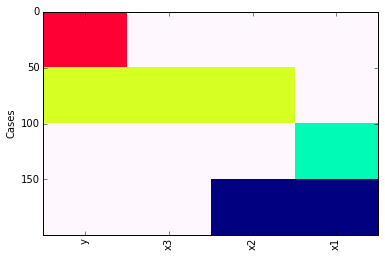

In [ ]:
_ = idata3.plot_missing_pattern(hide_complete_rows=True)

Here we set up and run the `MICE` object, specifying a linear regression with main effects for the analysis model.

In [ ]:
fml = "y ~ x1 + x2 + x3"
mi3 = mice.MICE(fml, sm.OLS, idata3)
mi3_results = mi3.fit(10, 10)

Here is the summary from the fitted logistic regression model in the final MICE iteration.  This is the model used to impute values of `x3`.

In [ ]:
print(idata3.results['x3'].summary())

Here is the results summary for the analysis model, based on combining information in the imputed data sets.

In [ ]:
print(mi3_results.summary())

The following plot shows the observed and fitted values for the observed and imputed cases.  We jitter the observed/imputed values a bit because they are binary.

In [ ]:
_ = idata3.plot_fit_obs('x3', jitter=(0.1, 0))